# Gesture Recognition using ASL

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, multilabel_confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
train = pd.read_csv('sign_mnist_train.csv')
test = pd.read_csv('sign_mnist_test.csv')

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
train.isnull()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27451,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27452,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27453,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
train.isna().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [6]:
train_df_original = train.copy()

# Split into training, test and validation sets
val_index = int(train.shape[0]*0.2)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

In [7]:
y = np.array(train_df['label'])
X = np.array(train_df.drop(columns='label'))

In [8]:
X.shape,y.shape

((21964, 784), (21964,))

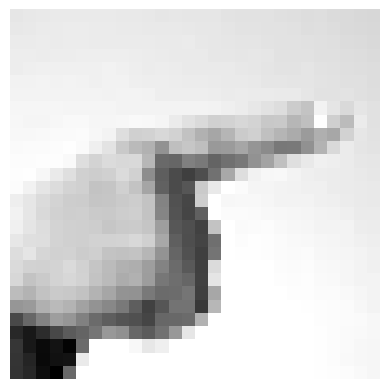

6


In [9]:
import random
r = random.randint(0,(21964-1))
def show_img():
  arr = np.array(X)
  some_value = arr[r]
  some_img = some_value.reshape(28,28)
  plt.imshow(some_img, cmap="gray")
  plt.axis("off")
  plt.show()  

show_img()
print(y[r])

In [10]:
y_train = pd.get_dummies(y)
y_train.head(5)

,0,1,2,3,4,5,6,7,8,10,...,15,16,17,18,19,20,21,22,23,24
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [11]:
y_val = val_df['label']
X_val = val_df.drop(columns="label",axis=1)
y_val = pd.get_dummies(y_val)

In [12]:
y_train.shape

(21964, 24)

In [13]:
X_val = pd.DataFrame(X_val).values.reshape(X_val.shape[0] ,28, 28, 1)
X_train = pd.DataFrame(X).values.reshape(X.shape[0] ,28, 28, 1)

In [14]:
X_train.shape,y_train.shape

((21964, 28, 28, 1), (21964, 24))

In [15]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)

X_train_flow = generator.flow(X_train, y_train, batch_size=32)

X_val_flow = generator.flow(X_val, y_val, batch_size=32)

### Generating Model 

In [16]:
model = Sequential()

model.add(Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))


model.add(Conv2D(filters=64,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))


model.add(Conv2D(filters=521,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)))
model.add(MaxPool2D((2,2),padding='SAME'))
model.add(Dropout(rate=0.2))



model.add(Flatten())
model.add(Dense(units=521, activation="relu"))
model.add(Dense(units=256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=24, activation="softmax"))


model.compile(loss="categorical_crossentropy", optimizer='adam',  metrics=["accuracy"])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [18]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001
)
history = model.fit(
    X_train_flow,
    validation_data=X_val_flow,
    # epochs=100,
    epochs=50,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss',
                   patience=5,
                   restore_best_weights=True
                   ),
      learning_rate_reduction
    ])

Epoch 1/50
687/687 [==============================] - 95s 135ms/step - loss: 3.1774 - accuracy: 0.0452 - val_loss: 3.1765 - val_accuracy: 0.0468 - lr: 0.0010
Epoch 2/50
687/687 [==============================] - 97s 142ms/step - loss: 2.9943 - accuracy: 0.0908 - val_loss: 2.0948 - val_accuracy: 0.3169 - lr: 0.0010
Epoch 3/50
687/687 [==============================] - 94s 137ms/step - loss: 1.4287 - accuracy: 0.5100 - val_loss: 0.5748 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 4/50
687/687 [==============================] - 91s 133ms/step - loss: 0.6667 - accuracy: 0.7658 - val_loss: 0.2720 - val_accuracy: 0.9086 - lr: 0.0010
Epoch 5/50
687/687 [==============================] - 88s 128ms/step - loss: 0.4266 - accuracy: 0.8557 - val_loss: 0.1734 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 6/50
687/687 [==============================] - 94s 137ms/step - loss: 0.3159 - accuracy: 0.8940 - val_loss: 0.1059 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 7/50
687/687 [==============================] 

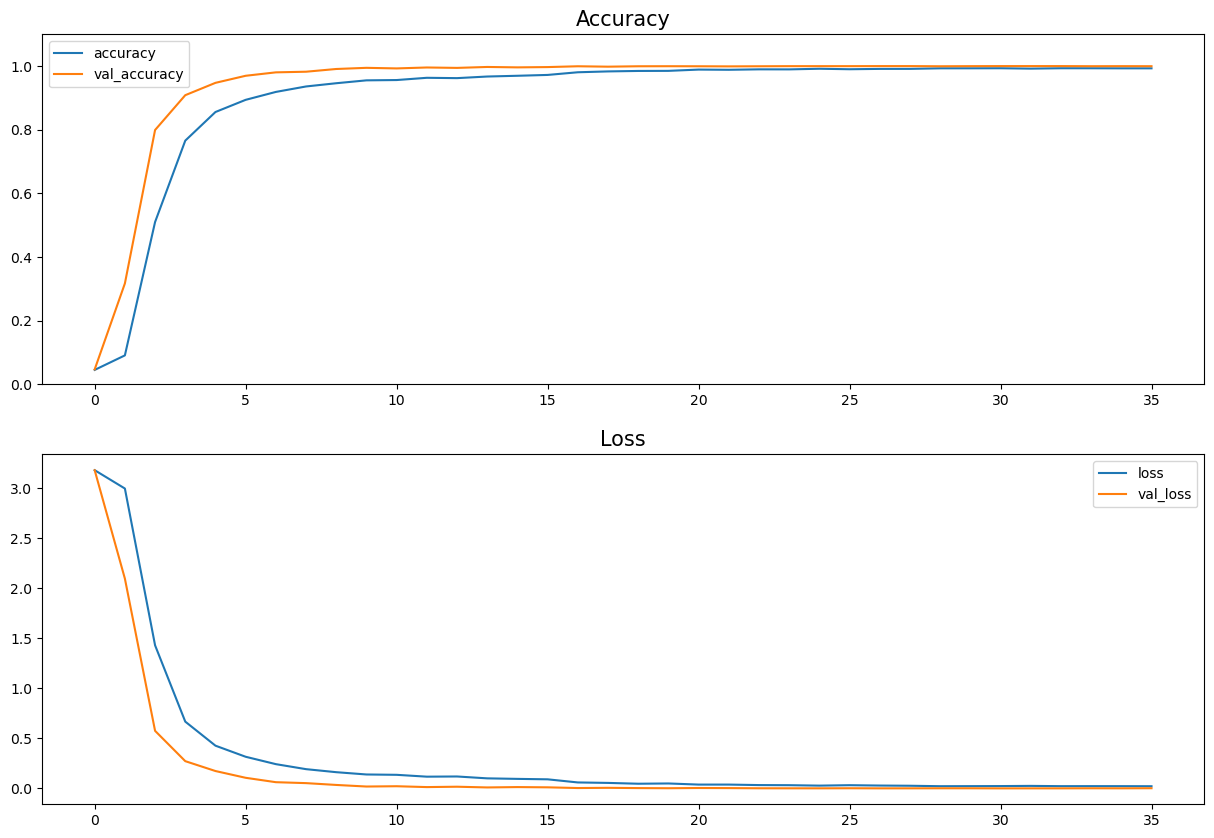

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [20]:
y_test = np.array(test['label'])
X_test = np.array(test.drop(columns='label'))

y_test = pd.get_dummies(y_test)
X_test = pd.DataFrame(X_test).values.reshape(X_test.shape[0] ,28, 28, 1)

y_test = pd.get_dummies(y_test)

In [21]:
from sklearn.metrics import classification_report
pred = model.predict(X_test)

y_pred = np.argmax(pred,axis=1)
y_test = np.argmax(y_test.values,axis=1)

225/225 [==============================] - 3s 13ms/step


### Accuracy Score

In [22]:
acc = accuracy_score(y_test,y_pred)

print(f' {acc*100:.2f}% accuracy on the test set')

 93.99% accuracy on the test set


### Classification report and Confusion Matrix

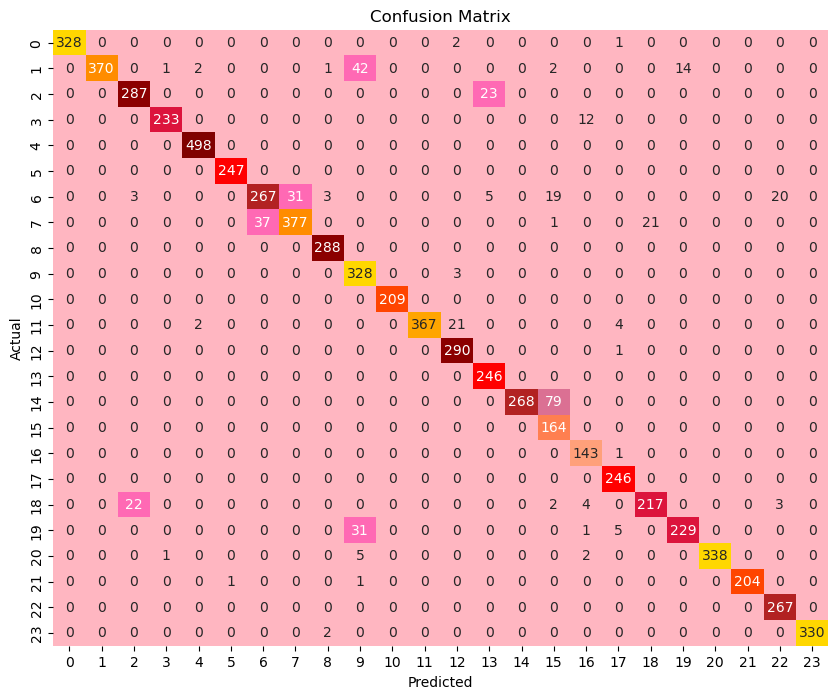

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       331
           1       1.00      0.86      0.92       432
           2       0.92      0.93      0.92       310
           3       0.99      0.95      0.97       245
           4       0.99      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       0.88      0.77      0.82       348
           7       0.92      0.86      0.89       436
           8       0.98      1.00      0.99       288
           9       0.81      0.99      0.89       331
          10       1.00      1.00      1.00       209
          11       1.00      0.93      0.96       394
          12       0.92      1.00      0.96       291
          13       0.90      1.00      0.95       246
          14       1.00      0.77      0.87       347
          15       0.61      1.00      0.76       164
          16       0.88      0.99      0.93       144
   

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
blush_palette = sns.color_palette(["#FFB6C1", "#FF69B4", "#FF1493", "#DB7093", "#C71585", "#FFC0CB", "#FFA07A", "#FF7F50", "#FF6347", "#FF4500", "#DC143C", "#FF0000", "#B22222", "#8B0000", "#800000", "#FFD700", "#FFA500", "#FF8C00", "#FF7F24", "#FF4500", "#FF0000", "#8B0000", "#800000"])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=blush_palette, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_rep)


## The CNN Model gives an accuracy of 94%